In [1]:
import datetime
from tqdm import tqdm
now = datetime.datetime.now()
print now.year, now.month, now.day, now.hour, now.minute, now.second

2018 3 2 6 17 12


In [2]:
from sklearn.datasets.base import Bunch

In [3]:
dd = {123: Bunch(seq=[1,1,4,5,6], info=['M', 52]),
      456: Bunch(seq=[2,1,4,5,6], info=['M', 52]),
      678: Bunch(seq=[3,1,4,5,6], info=['M', 52]),
      999: Bunch(seq=[4,1,4,5,6], info=['M', 52]),}

In [4]:
import multiprocessing as mp
import numpy as np
from multiprocessing import Manager

def f(i, shared_arg=None):
    return 2*np.array(shared_arg[i].seq)

manager = Manager()
shared_dict = manager.dict(dd)
pool = mp.Pool(4)

results = [pool.apply_async(f, [i, shared_dict]) for i in [123, 456, 678, 999]]
results = [p.get() for p in results]
results

[array([ 2,  2,  8, 10, 12]),
 array([ 4,  2,  8, 10, 12]),
 array([ 6,  2,  8, 10, 12]),
 array([ 8,  2,  8, 10, 12])]

In [1]:
import pandas as pd
import numpy as np
from __future__ import division

In [24]:
df = pd.read_csv('../tmp/dump_class_0.csv', header=0)
df.head()

,PTNT_ID
0,2917138437
1,2644508681
2,3505389578
3,2453667855
4,3314548753


In [85]:
n_jobs = 32

splits = np.array_split(df.values, n_jobs)

In [86]:
ss[0]

array([[2917138437],
       [2644508681],
       [3505389578],
       ...,
       [5105666806],
       [4600253182],
       [ 727862015]])

In [30]:
df.shape

(253180, 1)

In [7]:
import cPickle as pkl

# pp = pkl.load(open('../tmp/dump_class_0__raw_data_.pkl', 'rb'))

In [3]:
import os
mbs_files = filter(lambda x: x.startswith('MBS'), os.listdir('../../../data/'))
print(mbs_files)

['MBS_SAMPLE_10PCT_2010.csv', 'MBS_SAMPLE_10PCT_2013.csv', 'MBS_SAMPLE_10PCT_2008.csv', 'MBS_SAMPLE_10PCT_2009.csv', 'MBS_SAMPLE_10PCT_2011.csv', 'MBS_SAMPLE_10PCT_2014.csv', 'MBS_SAMPLE_10PCT_2012.csv']


In [4]:
___MBS_FILES_DICT__ = dict()
for mbs in mbs_files:
    mbs = os.path.join('..','..','..','data', mbs)
    dd = pd.read_csv(mbs, header=0, usecols=['PIN', 'ITEM', 'DOS'])
    print(dd.shape)
#     dd = dd.loc[~dd['ITEM'].isin(pregnancy_items), :]
    print(dd.shape)
    ___MBS_FILES_DICT__[mbs] = dd
    print('---')
    break

(41038001, 3)


NameError: name 'pregnancy_items' is not defined

In [ ]:
asd = pd.to_datetime(dd['DOS'], format='%d%b%Y') 

In [17]:
a = pd.DatetimeIndex(asd.values)
a.year[0]

2010

In [22]:
np.mean(a.year)

2010.0

In [23]:
aa = (0, 1)

In [24]:
aa[0]

0

In [30]:
_dd = pd.read_csv(os.path.join('..', 'mbspbs10pc', 'data', 'drugs_used_in_diabetes.csv'),
                     header=0)
# Fix 6-digit notation
dd = set()  # dd should be a set for performance reasons
for item in _dd.values.ravel():
    if len(item) < 6:
        dd.add(str(0)+item)
    else:
        dd.add(item)

In [38]:
ddd = ___MBS_FILES_DICT__[k]
ddd = ddd.set_index('PIN')
ddd.head()

,DOS,ITEM
PIN,,
1779689312,08SEP2010,36
2661651352,29JUN2010,23
8948401274,12JAN2010,57509
6745255963,14FEB2010,23
5742193063,10DEC2010,65105


In [39]:
ddd.loc[1779689312, ['DOS', 'ITEM']]

,DOS,ITEM
PIN,,
1779689312,08SEP2010,36
1779689312,23FEB2010,23
1779689312,23FEB2010,10990


In [2]:
tmp = pd.read_csv('../../../data/PBS_SAMPLE_10PCT_2009.csv', header=0, nrows=1000, usecols=['PTNT_ID', 'SPPLY_DT'])
tmp.loc[:, 'SPPLY_DT'] = pd.to_datetime(tmp['SPPLY_DT'], format='%d%b%Y')

In [3]:
tmp['SPPLY_DT'].max()

Timestamp('2009-12-31 00:00:00')

In [5]:
tmp['PTNT_ID'].values[-1]

1581741333

In [41]:
os.path.split(os.path.join('..', '..', 'asd', 'asd'))

('../../asd', 'asd')

In [31]:
k = mbs
first_dd = np.where(___MBS_FILES_DICT__[k]['ITEM'].isin(dd))[0][0]
small_mbs_dd[k].iloc[:first_dd,:]

/home/samu/miniconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [32]:
np.where(___MBS_FILES_DICT__[k]['ITEM'].isin(dd))

(array([], dtype=int64),)

In [9]:
pregnancy_items = set(pd.read_csv(os.path.join('../mbspbs10pc/data', 'pregnancy_items.csv'),
                                  header=0, usecols=['ITEM']).values.ravel())

In [10]:
pregnancy_items

{4001, 81000, 81005, 81010}

In [20]:
np.where(dd['ITEM'].isin(pregnancy_items))

(array([  208009,   209809,   222002,   223802,   231002,   399054,
          443996,   601876,   839473,  1012142,  1038529,  1228857,
         1587235,  1726866,  1730826,  1805644,  2136829,  2147533,
         2223407,  2397637,  2491529,  2524660,  2567537,  2618430,
         2622750,  2723199,  2791647,  2837473,  2895516,  2907036,
         3048537,  3089325,  3089685,  3229601,  3549188,  3657088,
         3854810,  3986901,  4140292,  4397293,  4475485,  4553401,
         4558081,  4755813,  4760493,  4764453,  4950280,  4958560,
         5005254,  5013534,  5021814,  5088953,  5400311,  5404978,
         5430448,  5595296,  5636136,  5706406,  5706543,  5870322,
         6042594,  6050154,  6161772,  6463228,  6897615,  6943585,
         6945025,  7300697,  7309007,  7434469,  7442905,  7643144,
         7989906,  8249070,  8261593,  8263753,  8308552,  8369820,
         8400288,  8418279,  8486433,  8488593,  8494494,  8512803,
         8955095,  8960495,  9185214,  9221666, 

In [16]:
imap = pd.read_csv('../data/imap.tsv', sep='\t', header=0,
                   usecols=['ITEM', 'BTOS'])

In [23]:
# dd.join(imap, on='ITEM', how='left')
cc = pd.merge(dd, imap, how='left', on='ITEM')
cc.head()

,PIN,DOS,ITEM,BTOS
0,1779689312,14JUL2014,23,101
1,7359101341,08OCT2014,23,101
2,8948401274,25DEC2014,10991,1100
3,6745255963,03JUL2014,23,101
4,4116763637,04OCT2014,302,200


In [25]:
dd.shape

(47166827, 3)

In [18]:
dd.columns

Index([u'PIN', u'DOS', u'ITEM'], dtype='object')

In [56]:
mbs_dd = ___MBS_FILES_DICT__

In [ ]:
raw_data = dict()

In [103]:
split = set(splits[0].ravel())

In [197]:
import time

In [199]:
import warnings
warnings.filterwarnings('ignore')

In [200]:
t1 = time.time()
raw_data = dict()

# Pre-filter: keep only the elements of mbs_dd that are in the current split
# this helps in reducing the time of the next step
small_mbs_dd = dict()
for k in tqdm(sorted(mbs_dd.keys())):
    # keep only a subset of the full MBS data
    small_mbs_dd[k] = mbs_dd[k].loc[mbs_dd[k]['PIN'].isin(split)]
    # change format to the right datetime format (this is gonna be useful later)
    small_mbs_dd[k].loc[:,'DOS'] = pd.to_datetime(small_mbs_dd[k]['DOS'], format='%d%b%Y')    
    # and sort by date
    small_mbs_dd[k].sort_values(by='DOS', inplace=True)

# Now track down each patient in the reduced MBS files
for s in tqdm(split):
    tmp = pd.DataFrame(columns=['PIN', 'DOS', 'SPR_RSP'])
    for k in sorted(mbs_dd.keys()):
        tmp = pd.concat((tmp, small_mbs_dd[k].loc[small_mbs_dd[k]['PIN'] == s]))
        
    # evaluate the first order difference and convert each entry in days
    timedeltas = map(lambda x: pd.Timedelta(x).days, tmp['DOS'].values[1:] - tmp['DOS'].values[:-1])
    # then build the sequence as ['exam', idle-days, 'exam', idle-days, ...]
    raw_data[s] = flatten([[str(spr_rsp), dt] for spr_rsp, dt in zip(tmp['SPR_RSP'].values, timedeltas)])
    raw_data[s].append(str(tmp['SPR_RSP'].values[-1]))
    
t2 = time.time()
print(t2-t1)

100%|██████████| 7912/7912 [02:08<00:00, 61.80it/s]

242.623284817


In [208]:
import multiprocessing as mp

In [209]:
mp.pool.ThreadPool()

In [210]:
!hostname

megazord


In [211]:
os.name

'posix'

In [212]:
dd = pkl.load(open('../tmp/dump_class_0__raw_data_.pkl','rb'))

In [213]:
raw_data = dd['raw_data']

In [224]:
from collections import Counter
Counter(raw_data[9061269504][::2])

Counter({10: 2,
         21: 105,
         32: 1,
         47: 8,
         51: 2,
         54: 5,
         90: 4,
         93: 14,
         104: 12,
         117: 29,
         130: 28,
         186: 2,
         448: 2,
         550: 8})

<Container object of 3 artists>

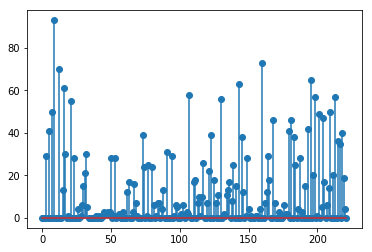

In [225]:
plt.stem(raw_data[9061269504][1::2])

In [216]:
import matplotlib.pyplot as plt
%matplotlib inline

In [221]:
np.arange(1, 11)[1::2]

array([ 2,  4,  6,  8, 10])

In [24]:
dd = pd.read_csv('../../../data/MBS_SAMPLE_10PCT_2008.csv',
                 header=0, usecols=['PIN', 'ITEM', 'DOS'],
                 nrows=10)
dd['DOS'] = pd.to_datetime(dd['DOS'], format='%d%b%Y')
dd.sort_values(by='DOS', inplace=True)
dd

,PIN,DOS,ITEM
1,2661651352,2008-01-24,73928
6,3990912150,2008-04-24,105
8,84860956,2008-04-25,10916
0,1779689312,2008-08-11,36
3,6745255963,2008-09-24,10991
7,7336900023,2008-10-09,23
9,4256465417,2008-10-23,73938
2,8948401274,2008-11-24,23
4,5742193063,2008-12-04,105
5,1101768849,2008-12-23,65120


In [25]:
date = dd['DOS'].values[3]
date

numpy.datetime64('2008-08-11T00:00:00.000000000')

In [29]:
dd[dd['DOS'] > date]

,PIN,DOS,ITEM
3,6745255963,2008-09-24,10991
7,7336900023,2008-10-09,23
9,4256465417,2008-10-23,73938
2,8948401274,2008-11-24,23
4,5742193063,2008-12-04,105
5,1101768849,2008-12-23,65120


In [21]:
dd.values[0]

array([1779689312, '11AUG2008', 36], dtype=object)

,PIN,DOS,ITEM
0,1779689312,11AUG2008,36
1,2661651352,24JAN2008,73928
2,8948401274,24NOV2008,23
3,6745255963,24SEP2008,10991
4,5742193063,04DEC2008,105
5,1101768849,23DEC2008,65120
6,3990912150,24APR2008,105
7,7336900023,09OCT2008,23
8,84860956,25APR2008,10916
9,4256465417,23OCT2008,73938
